# Link Prediction with GCN on WikiCS (Based on Chapter 10)

In [ ]:
%pip install torch torchvision torchaudio --quiet
%pip install torch-geometric --quiet
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: C:\Users\sviat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: C:\Users\sviat\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import torch
from torch_geometric.datasets import WikiCS
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import train_test_split_edges

dataset = WikiCS(root='data/WikiCS', transform=NormalizeFeatures())
data = dataset[0]

data.train_mask = data.train_mask[:, 0]
data.val_mask = data.val_mask[:, 0]
data.test_mask = data.test_mask

data = train_test_split_edges(data)


c:\Python312\Lib\site-packages\torch_geometric\datasets\wikics.py:45: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(
c:\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [ ]:
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAE(GCNEncoder(dataset.num_features, 64)).to(device)
x, train_pos_edge_index = data.x.to(device), data.train_pos_edge_index.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 20, Loss: 1.1850
Epoch 40, Loss: 1.1540
Epoch 60, Loss: 1.1282
Epoch 80, Loss: 1.1213
Epoch 100, Loss: 1.1209
Epoch 120, Loss: 1.1178
Epoch 140, Loss: 1.1178
Epoch 160, Loss: 1.1170
Epoch 180, Loss: 1.1175
Epoch 200, Loss: 1.1163


In [ ]:
model.eval()
with torch.no_grad():
    z = model.encode(x, train_pos_edge_index)

auc, ap = model.test(z,
                     data.test_pos_edge_index.to(device),
                     data.test_neg_edge_index.to(device))

print(f'AUC: {auc:.4f}, AP: {ap:.4f}')

AUC: 0.8391, AP: 0.8578


# Visualizing of node embeddings using t-SNE

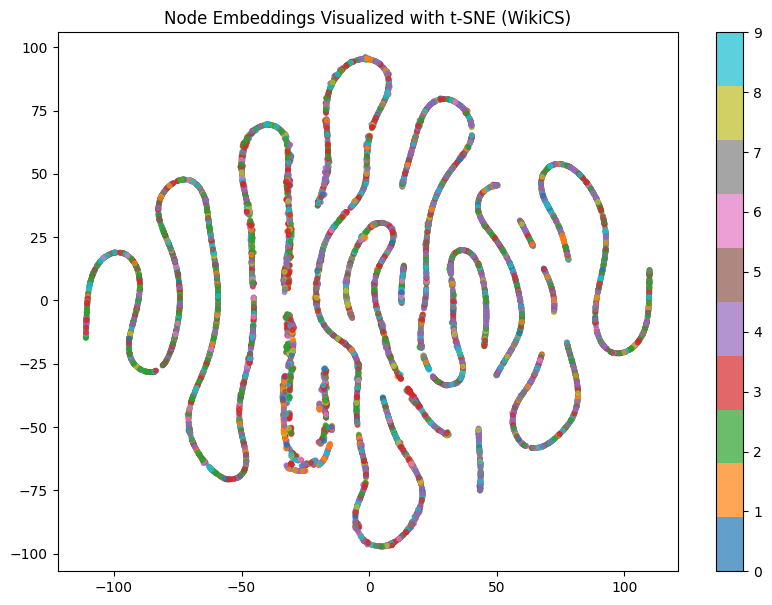

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.train_pos_edge_index)
    z = z.cpu().numpy()
    y = data.y.cpu().numpy()

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y, cmap='tab10', s=10, alpha=0.7)
plt.title('Node Embeddings Visualized with t-SNE (WikiCS)')
plt.colorbar(scatter)
plt.show()
